In [1]:
from pylab import *
import pandas as pd
from sklearn import datasets
%matplotlib inline

# 1. Load Log from std::cout

In [2]:
machine = 'ryzen'

with open("../log/{}_toyDetector_100layer.log".format(machine)) as f:
    lines = f.readlines()
runtimes = []
for line in lines:
    if line == 'Start to run CLUE algorithm\n':
        runtime = []
    if line == 'Finished running CLUE algorithm\n':
        runtimes.append(runtime)
    if line[0:13]=="Elapsed time:":
        runtime.append(float(line[13:-3]))
cpu100 = np.array(runtimes[ 0:10]) [:,1:]
gpu100 = np.array(runtimes[10:20]) [:,1:]
cuplaTBB100 = np.array(runtimes[ 20:30]) [:,1:] 
cuplaSerial100 = np.array(runtimes[ 30:40]) [:,1:] 
cuplaCuda100 = np.array(runtimes[ 40:50]) [:,1:] 

with open("../log/{}_toyDetector_1layer.log".format(machine)) as f:
    lines = f.readlines()
runtimes = []
for line in lines:
    if line == 'Start to run CLUE algorithm\n':
        runtime = []
    if line == 'Finished running CLUE algorithm\n':
        runtimes.append(runtime)
    if line[0:13]=="Elapsed time:":
        runtime.append(float(line[13:-3]))
cpu1 = np.array(runtimes[ 0:10])[:,1:] 
gpu1 = np.array(runtimes[10:20])[:,1:]
cuplaTBB1 = np.array(runtimes[ 20:30]) [:,1:] 
cuplaSerial1 = np.array(runtimes[ 30:40]) [:,1:] 
cuplaCuda1 = np.array(runtimes[ 40:50]) [:,1:] 

# 2. Load Log from nvprof

In [3]:
with open("../log/{}_toyDetector_100layer_nvprof.log".format(machine)) as f:
    lines = f.readlines()
    
HToD,DtoH,k1,k2,k3,k4,k5,memset = [],[],[],[],[],[],[],[]
for line in lines:  
    wordsInLine = line.split("  ")
    
    if wordsInLine[-1] == "[CUDA memcpy HtoD]\n":
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        HToD.append(time)
        
    if wordsInLine[-1] == "[CUDA memcpy DtoH]\n":
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        DtoH.append(time)
        
    if wordsInLine[-1] == "cudaMemset\n":
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        memset.append(time)
                
        
    name = "kernel_compute_histogram"
    if wordsInLine[-1][:len(name)] == name:
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        k1.append(time)
            
    name = "kernel_compute_density"
    if wordsInLine[-1][:len(name)] == name:
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        k2.append(time)
    
    name = "kernel_compute_distanceToHigher"
    if wordsInLine[-1][:len(name)] == name:
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        k3.append(time)
        
    name = "kernel_find_clusters"
    if wordsInLine[-1][:len(name)] == name:
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        k4.append(time)
        
    name = "kernel_assign_clusters"
    if wordsInLine[-1][:len(name)] == name:
        word = wordsInLine[-9]
        time = float(word[:-2])
        if word[-2:] == "us":
            time /= 1000
        k5.append(time)
        
prof100 = np.array([HToD,DtoH,memset,k1,k2,k3,k4,k5])/10


# 3. Plot

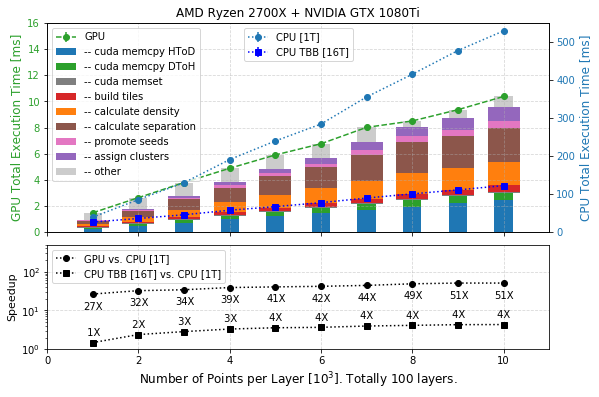

In [4]:
fig, axex = plt.subplots( 2,1, sharex=True, figsize=(9,6),facecolor='w',gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0.08)

n = np.arange(1,11,1)

##########################
ax1= axex[0]
ax2 = ax1.twinx()

# ax1.errorbar(n, cuplaCuda100.mean(axis=1),yerr=cuplaCuda100.std(axis=1), marker='*',linestyle='--',color='C3',label=r'CUPLA CUDA')
ax1.errorbar(n, gpu100.mean(axis=1),yerr=gpu100.std(axis=1), marker='o',linestyle='--',color='C2',label=r'GPU')
prof = prof100
but = np.cumsum(prof,axis=0)

labels = [
          "-- cuda memcpy HToD",
          "-- cuda memcpy DToH",
          "-- cuda memset",
          "-- build tiles",
          "-- calculate density",
          "-- calculate separation",
          "-- promote seeds",
          "-- assign clusters",
          "-- other"
         ]

colors = ["C0", "C2", "C7","C3","C1","C5", "C6","C4", "0.8" ]


ax1.bar(n, prof[0],label= labels[0],width=0.4, facecolor=colors[0])
ax1.bar(n, prof[1], bottom=but[0],label= labels[1],width=0.4, facecolor=colors[1] )
for i in range(2,8):
    ax1.bar(n, prof[i], bottom=but[i-1],label= labels[i],width=0.7, facecolor=colors[i] )
other = gpu100.mean(axis=1) - but[7]
ax1.bar(n, other, bottom=but[7],width=0.4,label= labels[8], facecolor=colors[8] )

ax1.set_ylim(0,16)
ax1.set_xlim(0,11)
ax1.grid(linestyle='--',alpha=0.5)
ax1.legend(fontsize=10)

ax1.set_ylabel("GPU Total Execution Time [ms]",fontsize=12,color="C2")
ax1.tick_params(axis='y', labelcolor="C2")
ax1.set_title("AMD Ryzen 2700X + NVIDIA GTX 1080Ti",fontsize=12)
# ax1.set_title("100 layers. Tested on Intel Xeon Silver 4114 [40T]+ NVIDIA Tesla V100 ",fontsize=12)

ax2.errorbar(n, cpu100.mean(axis=1),yerr=cpu100.std(axis=1), marker='o',linestyle=':',color="C0",label=r'CPU [1T]')
# x2.errorbar(n, cuplaSerial100.mean(axis=1),yerr=cuplaSerial100.std(axis=1), marker='^',linestyle='--',color='0.5',label=r'CUPLA CPU Serial [1T]')
ax2.errorbar(n, cuplaTBB100.mean(axis=1),yerr=cuplaTBB100.std(axis=1), marker='s',linestyle=':',color="b",label=r'CPU TBB [16T]')
ax2.legend(fontsize=10,loc="upper center")
ax2.set_ylim(0,550)
ax2.tick_params(axis='y', labelcolor="C0")
ax2.set_ylabel("CPU Total Execution Time [ms]",fontsize=12,color="C0")

##########################
ax3 = axex[1]
speedup= cpu100.mean(axis=1)/gpu100.mean(axis=1)
ax3.plot(n, speedup, marker='o',linestyle=':',color="k",label='GPU vs. CPU [1T]')

for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]/2.5,"{:2.0f}X".format(speedup[i]))
    

speedup= cpu100.mean(axis=1)/cuplaTBB100.mean(axis=1)
ax3.plot(n, speedup, marker='s',linestyle=':',color="k",label='CPU TBB [16T] vs. CPU [1T]')
for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]*1.5,"{:2.0f}X".format(speedup[i]))
    
ax3.set_xlabel(r"Number of Points per Layer [$10^3$]. Totally 100 layers.",fontsize=12)
ax3.legend(fontsize=10,loc="upper left")
ax3.set_ylabel("Speedup",fontsize=11,color="k")
ax3.set_ylim(1,500)
ax3.grid(linestyle='--',alpha=0.5)
ax3.set_yscale("log")

plt.savefig("../plots/Figure5.pdf")
plt.savefig("../plots/Figure5.png",dpi=400)